# **Lab 6 Transfer Learning & Hyperparameter Tuning**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.

In [2]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, gauss_noise=False, gauss_blur=None, resize=128, p=0.5):
        self.p = p
        self.resize = resize
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def apply_gaussian_noise(self, image):
        if random.random() < self.p:
            mean = random.uniform(-50, 50)
            std_dev = 25
            noise = np.random.normal(mean, std_dev, image.shape).astype(np.float32)
            noisy_image = cv2.add(image.astype(np.float32), noise)
            noisy_image = np.clip(noisy_image, 0, 255).astype(np.float32)
            return noisy_image
        return image

    def apply_gaussian_blur(self, image):
        if random.random() < self.p:
            ksize = random.choice(range(3, 12, 2))
            image = cv2.GaussianBlur(image, (ksize, ksize), 0)
        return image

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (self.resize, self.resize))

        gt_image = image.copy()

        if self.gauss_noise:
            image = self.apply_gaussian_noise(image)

        if self.gauss_blur:
            image = self.apply_gaussian_blur(image)

        image = image.astype(np.float32) / 255.0
        gt_image = gt_image.astype(np.float32) / 255.0

        return torch.tensor(image).permute(2, 0, 1), torch.tensor(gt_image).permute(2, 0, 1)
### END CODE HERE ###

In [3]:
### START CODE HERE ###
def imshow_grid(images):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()
    
    for img, ax in zip(images, axes):
        img_np = img.permute(1, 2, 0).numpy()
        ax.imshow(np.clip(img_np, 0, 1))
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
### END CODE HERE ###

In [4]:
### START CODE HERE ###
data_dir = r'C:\Users\Nickv\Documents\ImageProcessing\Week5\img_align_celeba'
image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]
dataset = CustomImageDataset(image_paths=image_paths, gauss_noise=True, gauss_blur=True, resize=128, p=0.5)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
### END CODE HERE ###

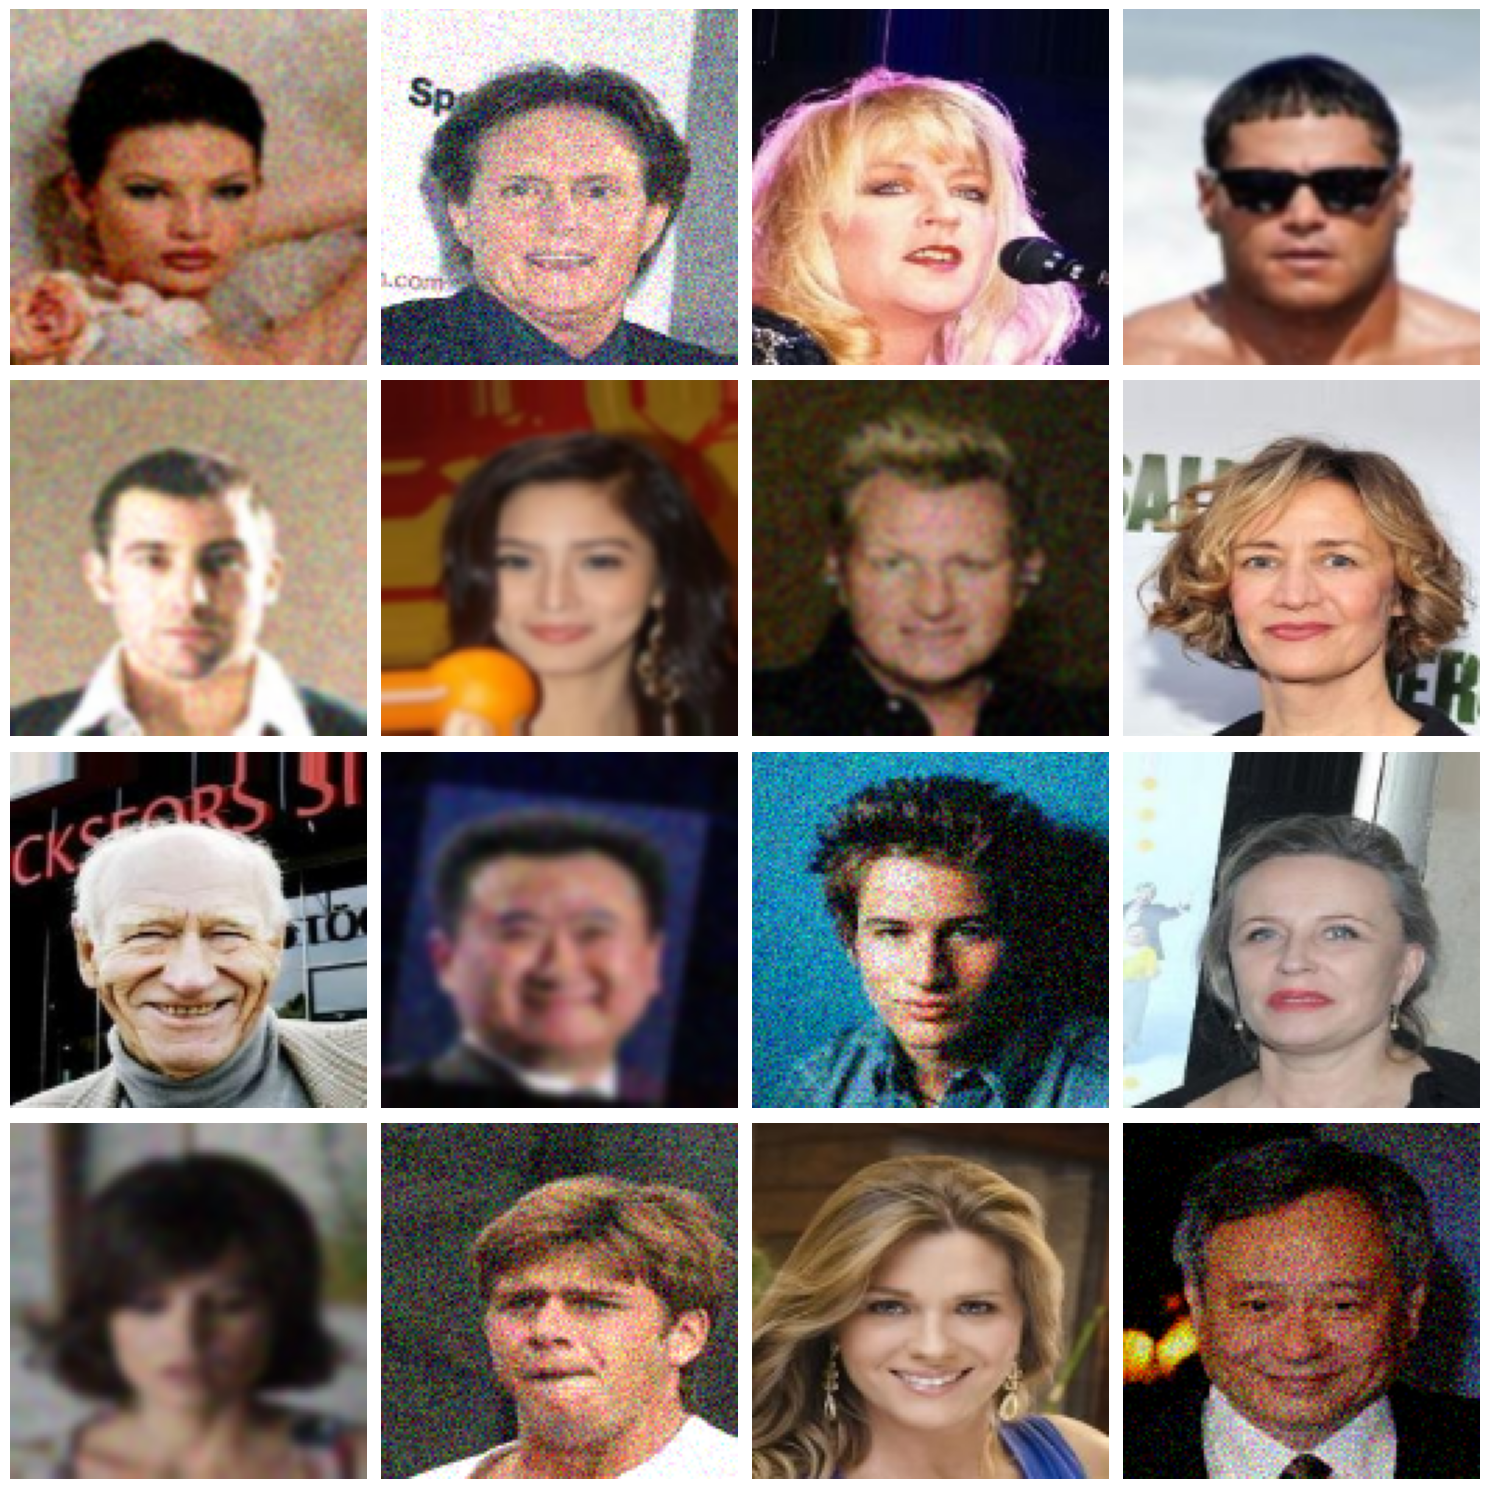

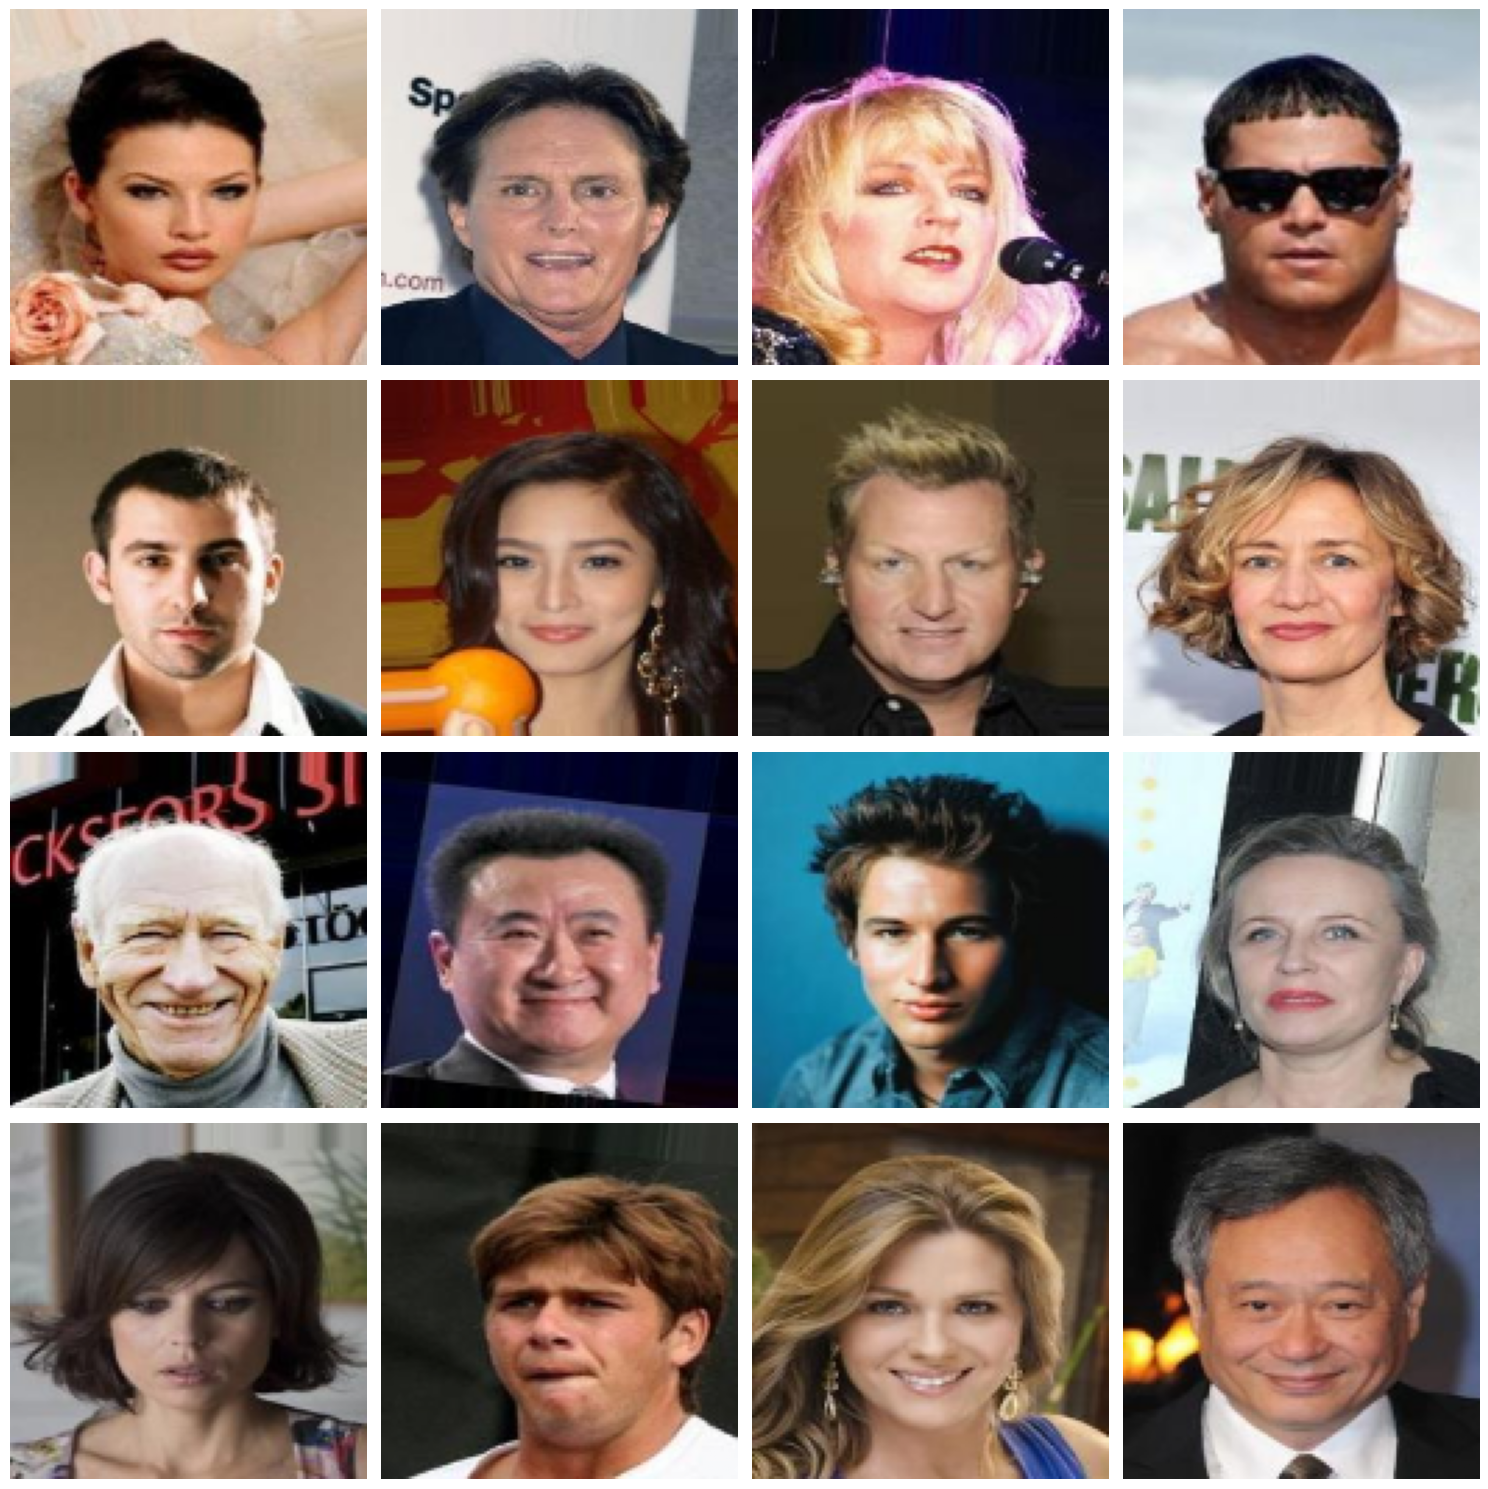

In [5]:
### START CODE HERE ###
batch, gt_img = next(iter(dataloader)) 

imshow_grid(batch)
imshow_grid(gt_img)

### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model with a customizable number of downsampling and upsampling blocks by passing a list of channel numbers for each layer based on the provided code below. However, please maintain the concept of 'Autoencoder'.

In [6]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, channels=[64, 128, 256], input_channels=3, output_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            DownSamplingBlock(input_channels, channels[0]),
            DownSamplingBlock(channels[0], channels[1]),
            DownSamplingBlock(channels[1], channels[2])
        )

        self.decoder = nn.Sequential(
            UpSamplingBlock(channels[2], channels[1]),
            UpSamplingBlock(channels[1], channels[0]),
            UpSamplingBlock(channels[0], channels[0])
        )
        
        self.final_conv = nn.Conv2d(channels[0], output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final_conv(x)

        return x

### END CODE HERE ###

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [7]:
### START CODE HERE ###
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cuda'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, gt in train_bar:
            images = images.to(device)
            gt = gt.to(device)
            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, gt)
            loss.backward()
            opt.step()

            avg_train_loss += loss.item()
            step += 1

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss /= step
        
        model.eval()
        avg_test_loss = 0.0
        test_bar = tqdm(test_loader, desc='📄 Testing', unit='batch')
            
        for images, gt in test_bar:
            images = images.to(device)
            gt = gt.to(device)
            output = model(images)
            loss = loss_fn(output, gt)
            avg_test_loss += loss.item()

        avg_test_loss /= len(test_loader)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    if checkpoint_path:
        torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")
                
### END CODE HERE ###

Let's train your model with 2 epochs to verify that your train() function works properly. After that, we'll move on to the Hyperparameter Grid Search in the next part.

In [58]:
### START CODE HERE ###

data_dir = r'C:\Users\Nickv\Documents\ImageProcessing\Week5\img_align_celeba'

files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]


train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)


train_dataset = CustomImageDataset(image_paths=train_files, gauss_noise=True, gauss_blur=True)
test_dataset = CustomImageDataset(image_paths=test_files, gauss_noise=False, gauss_blur=False)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
### END CODE HERE ###

In [59]:
### START CODE HERE ###

model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train(model, opt, loss_fn, trainloader, testloader, epochs=2, checkpoint_path='autoencoder.pth')

### END CODE HERE ###

🤖 Training on cuda


📄 Testing: 100%|██████████| 563/563 [00:13<00:00, 40.22batch/s]

Epoch [2/2], Train Loss: 0.0109, Test Loss: 0.0089
🏁 Training completed.


---

## **Hyperparameter Grid Search with Raytune**

*If you have access to APEX, I would recommend converting this part into a Python file and submitting the job to run on APEX using SBATCH. This process may take a considerable amount of time.*

You can import additional Ray Tune tools as you want, such as schedulers, search algorithms, etc. Further information on the usage of Ray Tune can be found [here](https://docs.ray.io/en/latest/tune/index.html).

In [1]:
import ray
from ray import tune
from ray.air import session
from ray.air import RunConfig


ray.shutdown()

Complete the `train_raytune()` function below, following the [quick start guide](https://docs.ray.io/en/latest/tune/index.html). This function will be passed to the `tune.Tuner`.

In [24]:
### START CODE HERE ###
def train_raytune(config):

    architecture = config["architecture"]
    lr = config["lr"]
    batch_size = config["batch_size"]
    num_epochs = config["num_epochs"]
    optimizer = config["optimizer"]

    train_files, test_files = train_test_split(r'C:\Users\Nickv\Documents\ImageProcessing\Week5\img_align_celeba', test_size=0.2, random_state=42)
    train_dataset = CustomImageDataset(image_paths=train_files,
                                gauss_noise=True,
                                gauss_blur=True,
                                resize=128,
                                p=0.5
                                )
    test_dataset = CustomImageDataset(image_paths=test_files,
                                gauss_noise=True,
                                gauss_blur=True,
                                resize=128,
                                p=0.5
                                )

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Autoencoder(architecture)
    model = model.to(device)
    loss_fn = nn.MSELoss()

    if optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = 0
        avg_test_loss = 0
        for batch in trainloader:
            images, train_gt_img = batch

            images = images.to(device)
            train_gt_img = train_gt_img.to(device)
            output = model(images)
            loss = loss_fn(output, train_gt_img)
            opt.zero_grad()
            loss.backward()
            opt.step()
            avg_train_loss += loss.item()

        avg_train_loss /= len(trainloader)
        
        total_psnr = 0
        total_ssim = 0
        model.eval()
        with torch.no_grad():
            for batch in testloader:
                images, test_gt_img = batch
                images = images.to(device)
                test_gt_img = test_gt_img.to(device)
                
                output = model(images)
                
                loss = loss_fn(output, test_gt_img)
                avg_test_loss += loss.item()
                
                output_np = output.cpu().numpy().transpose(0, 2, 3, 1)
                images_np = test_gt_img.cpu().numpy().transpose(0, 2, 3, 1)
                
                for i in range(images_np.shape[0]):
                    img = images_np[i]
                    rec_img = output_np[i]
                    total_psnr += psnr(img, rec_img, data_range=1.0)
                    
                    min_dim = min(img.shape[0], img.shape[1])
                    win_size = min(7, min_dim)
                    if win_size % 2 == 0:
                        win_size -= 1  
                    total_ssim += ssim(img, rec_img, win_size=win_size, data_range=1.0, channel_axis=2)
        
        avg_psnr = total_psnr / (len(testloader.dataset))
        avg_ssim = total_ssim / (len(testloader.dataset))
        avg_test_loss /= len(testloader)
        
        session.report({
            "train_loss": avg_train_loss,
            "val_loss": avg_test_loss,
            "val_psnr": avg_psnr,
            "val_ssim": avg_ssim,
        })
        
### END CODE HERE ###

Initialize Ray, define the search space, and resources.

Resource : 
- [A Guide To Parallelism and Resources for Ray Tune](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html#:~:text=A%20Guide%20To%20Parallelism%20and%20Resources%20for%20Ray%20Tune) 
- [Working with Tune Search Spaces](https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial:~:text=Working%20with%20Tune%20Search%20Spaces)
- [How to configure logging in Tune?](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html) 
- [Tune Trial Schedulers (`tune.schedulers`)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-pbt:~:text=Tune%20Trial...-,Tune%20Trial%20Schedulers%20(tune.schedulers),-%23)

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [ ]:
### START CODE HERE ###
ray.shutdown()
ray.init(num_gpus=1)

def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

config = {
    'architecture': tune.grid_search([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),
    'lr': tune.grid_search([1e-3, 8e-4, 1e-4, 1e-2]),
    'batch_size': tune.grid_search([16, 32]),
    'num_epochs': tune.grid_search([10, 50, 100]),
    'optimizer': tune.grid_search(["Adam", "SGD"]),
}

result = tune.run(
    tune.with_resources(train_raytune, resources={"gpu": 0.5}),
    config=config,
    metric="val_psnr",
    mode="max",
    trial_dirname_creator=short_dirname
)

print("Best config: ", result.get_best_config(metric="val_psnr", mode="max"))
### END CODE HERE ###

Restore the result from path of ray resule directory

In [ ]:
### START CODE HERE ###
import pandas as pd
path = r"C:\Users\Nickv\Documents\ImageProcessing\Week6\train_raytune_2024-09-27_12-44-33"

best_val_psnr = float('-inf')
best_info = {}

for trial_folder in os.listdir(path):
    trial_path = os.path.join(path, trial_folder)
    progress_file = os.path.join(trial_path, 'progress.csv')

    if os.path.isfile(progress_file):

        df = pd.read_csv(progress_file)

        if 'val_psnr' in df.columns:
            max_val_psnr_row = df.loc[df['val_psnr'].idxmax()]

            if max_val_psnr_row['val_psnr'] > best_val_psnr:
                best_val_psnr = max_val_psnr_row['val_psnr']
                best_info = {
                    'trial_folder': trial_folder,
                    'val_psnr': max_val_psnr_row['val_psnr'],
                    'iterations_since_restore': max_val_psnr_row['iterations_since_restore'],
                    'progress_df': df
                }
### END CODE HERE ###

Get the report from Grid Search to CSV file.

In [ ]:
import json

best_path = os.path.join(path,best_info['trial_folder'])
with open(os.path.join(best_path,'params.json'), 'r') as file:
    best_param = json.load(file)

print("🎉[INFO] Training is done!")
print("Best config is:", best_param)
print("Best result is:", best_info['trial_folder'],f"Iterations number: {best_info['iterations_since_restore']}",f"which has best val_psnr: {best_val_psnr}")
df = best_info['progress_df']
print(df)


---

Train the Autoencoder models using the best hyperparameter set obtained from the grid search.

In [ ]:
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, channels=[64, 128, 256, 512], input_channels=3, output_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            DownSamplingBlock(input_channels, channels[0]),
            DownSamplingBlock(channels[0], channels[1]),
            DownSamplingBlock(channels[1], channels[2]),
            DownSamplingBlock(channels[2], channels[3])
        )

        self.decoder = nn.Sequential(
            UpSamplingBlock(channels[3], channels[2]),
            UpSamplingBlock(channels[2], channels[1]),
            UpSamplingBlock(channels[1], channels[0]),
            UpSamplingBlock(channels[0], channels[0])
        )
        
        self.final_conv = nn.Conv2d(channels[0], output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final_conv(x)

        return x

In [ ]:
### START CODE HERE ###

data_dir = r"C:\Users\ADMIN\Desktop\coding\imageprocessing\lab6\img_align_celeba"
files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]


train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)


train_dataset = CustomImageDataset(image_paths=train_files, gauss_noise=True, gauss_blur=True)
test_dataset = CustomImageDataset(image_paths=test_files, gauss_noise=False, gauss_blur=False)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train(model, opt, loss_fn, trainloader, testloader, epochs=100, checkpoint_path='autoencoder.pth')

### END CODE HERE ###

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers. Then, save it as an image.


In [13]:
import math
class FeatureMapVisualizer:
    def __init__(self, model, layers, save_dir):
        """
        Parameters:
        - model: The PyTorch model
        - layers: A string or list of strings specifying the layer names to visualize
        - save_dir: Directory to save the output feature map images
        """
        self.model = model
        self.layers = layers if isinstance(layers, list) else [layers]
        self.activations = {}
        self.save_dir = save_dir

        os.makedirs(self.save_dir, exist_ok=True)

        self._register_hooks()

    def _register_hooks(self):
        for name, layer in self.model.named_modules():
            if name in self.layers:
                layer.register_forward_hook(self._hook_fn(name))

    def _hook_fn(self, layer_name):
        def hook(module, input, output):
            print(f'Hooking layer: {layer_name}')
            self.activations[layer_name] = output.detach()
        return hook

    def visualize(self, input_paths):
        """
        Pass an input tensor through the model and visualize the activations.
        
        Parameters:
        - input_paths: List of image paths to pass through the model
        """
        
        for img_path in input_paths:
            self.model(img_path)

            for layer_name, activation in self.activations.items():
                print(f'Visualizing and saving layer: {layer_name}')
                self._save_feature_maps(activation, layer_name)

    def _save_feature_maps(self, activation, layer_name):
        ### START CODE HERE ###
        num_channels = activation.shape[1]
        cols = 8
        rows = math.ceil(num_channels / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

        for i in range(num_channels):
            ax = axes[i // cols, i % cols]
            feature_map = activation[0, i].cpu().numpy()
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')

        for j in range(i + 1, rows * cols):
            fig.delaxes(axes[j // cols, j % cols])
        
        plt.suptitle(f"Feature Maps from Layer: {layer_name}")
        plt.tight_layout()

        plt.savefig(os.path.join(self.save_dir, f"{layer_name}_feature_maps.png"))
        plt.close()

        ### END CODE HERE ###

In [ ]:
### START CODE HERE ###

data_dir = r'C:\Users\Nickv\Documents\ImageProcessing\Week5\img_align_celeba'
image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]
dataset = CustomImageDataset(image_paths, gauss_noise=True, gauss_blur=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader))



layers_to_visualize = ['encoder', 'decoder', 'final_conv']
visualizer = FeatureMapVisualizer(model, layers_to_visualize, r'C:\Users\ADMIN\Desktop\coding\imageprocessing\lab6')
visualizer.visualize(images)


### END CODE HERE ###

---
## **Hyperparameter Random Search with Raytune**

**Search Space:**

- **`architecture`:**  
    Define the feature map dimensions for convolutional layers:  
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with additional depth, starting from 64 and ending at 512.
  
- **`learning rates (lr)`**:  
    A continuous range of learning rates sampled uniformly between `1e-4` and `1e-2`. This allows exploration of different learning rates from conservative (`1e-4`) to more aggressive (`1e-2`) values.

- **`batch size`**:  
    Randomly sample an integer batch size between 16 and 32 (inclusive). This allows testing of smaller batch sizes, which can affect gradient estimation and memory usage.

- **`number of epochs`**:  
    Randomly sample an integer number of epochs between 10 and 100. This allows the model to train for short (e.g., 10 epochs) or extended periods (up to 100 epochs), giving insight into model performance over different training durations.

- **`optimizers (opts)`**:  
    Randomly select between two optimizers:  
    - `"Adam"`: An adaptive learning rate optimizer that generally performs well across various tasks.  
    - `"SGD"`: Stochastic Gradient Descent with momentum, commonly used for large-scale tasks, requiring careful tuning of the learning rate.

***NOTE*** Random search with 80 samples.

In [ ]:
### START CODE HERE ###
ray.shutdown()
ray.init(num_gpus=1)

def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

config = {
    'architecture': tune.choice([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),
    "lr": tune.uniform(1e-4, 1e-2), 
    "batch_size": tune.randint(16, 33),
    "num_epochs": tune.randint(10, 101),
    'optimizer': tune.choice(['Adam', 'SGD']),
}

result = tune.run(
    tune.with_resources(train_raytune, resources={"gpu": 0.5}),
    config=config,
    metric="val_psnr",
    mode="max",
    num_samples=30,
    trial_dirname_creator=short_dirname,
)

print("Best config: ", result.get_best_config(metric="val_psnr", mode="max"))

### END CODE HERE ###

In [ ]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()
df.to_csv('', index=False)

# ray.shutdown()

---

Train the Autoencoder models using the best hyperparameter set obtained from the random search.

In [9]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cuda'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, gt in train_bar:
            images = images.to(device).float() / 255.0
            gt = gt.to(device).float() / 255.0
            images = images.permute(0, 1, 3, 2)
            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, gt)
            loss.backward()
            opt.step()

            avg_train_loss += loss.item()
            step += 1

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss /= step
        
        model.eval()
        avg_test_loss = 0.0
        test_bar = tqdm(test_loader, desc='📄 Testing', unit='batch')
            
        for images, gt in test_bar:
            images = images.to(device)
            gt = gt.to(device)
            output = model(images)
            loss = loss_fn(output, gt)
            avg_test_loss += loss.item()

        avg_test_loss /= len(test_loader)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    if checkpoint_path:
        torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")

In [10]:
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_in = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.down1 = DownSamplingBlock(64, 128, kernel_size=3, stride=1, padding=1)
        ### DESIGN YOUR OWN MODEL ###
        self.down2 = DownSamplingBlock(128, 256, kernel_size=3, stride=1, padding=1)
        self.down3 = DownSamplingBlock(256, 512, kernel_size=3, stride=1, padding=1)
        
        self.up1 = UpSamplingBlock(512, 256, kernel_size=3, stride=1, padding=1)
        self.up2 = UpSamplingBlock(256, 128, kernel_size=3, stride=1, padding=1)
        self.up3 = UpSamplingBlock(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv_in(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)

        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.conv_out(x)
        return x

In [11]:
### START CODE HERE ###

data_dir = r'C:\Users\Nickv\Documents\ImageProcessing\Week5\img_align_celeba'

files = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]

train_files, test_files = train_test_split(files, test_size=0.3, random_state=2024)


train_dataset = CustomImageDataset(image_paths=train_files, gauss_noise=True, gauss_blur=True)
test_dataset = CustomImageDataset(image_paths=test_files, gauss_noise=False, gauss_blur=False)

trainloader = DataLoader(train_dataset, batch_size=19, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=19, shuffle=False, num_workers=0)

model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.0007686928707777884)
loss_fn = nn.MSELoss()
train(model, opt, loss_fn, trainloader, testloader, epochs=88, checkpoint_path='autoencoder.pth')

### END CODE HERE ###

🤖 Training on cuda


📄 Testing: 100%|██████████| 474/474 [00:20<00:00, 23.05batch/s]

Epoch [88/88], Train Loss: 0.0000, Test Loss: 0.3182
🏁 Training completed.


Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.

In [35]:
### START CODE HERE ###

class FeatureMapVisualizer:
    def __init__(self, model, layers, save_dir):
        self.model = model
        self.layers = layers if isinstance(layers, list) else [layers]
        self.activations = {}
        self.save_dir = save_dir

        os.makedirs(self.save_dir, exist_ok=True)

        self._register_hooks()

    def _register_hooks(self):
        for name, layer in self.model.named_modules():
            if name in self.layers:
                layer.register_forward_hook(self._hook_fn(name))

    def _hook_fn(self, layer_name):
        def hook(module, input, output):
            print(f'Hooking layer: {layer_name}')
            self.activations[layer_name] = output.detach()
        return hook

    def visualize(self, input_tensors):
        if not isinstance(input_tensors, list):
            input_tensors = [input_tensors]

        for idx, img_tensor in enumerate(input_tensors):
            with torch.no_grad():
                self.model(img_tensor)

            for layer_name, activation in self.activations.items():
                print(f'Visualizing and saving layer: {layer_name}')
                img_feature_map_dir = os.path.join(self.save_dir, f'image_{idx}')
                os.makedirs(img_feature_map_dir, exist_ok=True)
                
                self._save_feature_maps(activation, layer_name, img_feature_map_dir)

    def _save_feature_maps(self, activation, layer_name, img_feature_map_dir):
        num_channels = activation.shape[1]
        cols = 8
        rows = math.ceil(num_channels / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

        if rows == 1:
            axes = [axes]
        axes = np.array(axes).reshape(rows, cols)

        for i in range(num_channels):
            ax = axes[i // cols, i % cols]
            feature_map = activation[0, i].cpu().numpy()
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')

        for j in range(i + 1, rows * cols):
            fig.delaxes(axes[j // cols, j % cols])
        
        plt.suptitle(f"Feature Maps from Layer: {layer_name}")
        plt.tight_layout()

        plt.savefig(os.path.join(img_feature_map_dir, f"{layer_name}_feature_maps.png"))
        plt.close()

### END CODE HERE ###

In [16]:
model = Autoencoder()
model.load_state_dict(torch.load(r'C:\Users\Nickv\Documents\ImageProcessing\Week6\autoencoder.pth_epoch_88.pth'))
model.eval()

C:\Users\Nickv\AppData\Local\Temp\ipykernel_30408\939802470.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\Nickv\Documents\I

Autoencoder(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): DownSamplingBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownSamplingBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): DownSamplingBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (up1): UpSamplingBlock(
    (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  )
  (up2): UpSamplingBlock(
    (conv): Conv2d(256, 128, kernel

In [26]:
data_dir = r'C:\Users\Nickv\Documents\ImageProcessing\Week5\img_align_celeba'
image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]
dataset = CustomImageDataset(image_paths, gauss_noise=True, gauss_blur=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader))

In [36]:
### START CODE HERE ###

layers_to_visualize = ['conv_in', 'down1', 'down2', 'down3', 'up1', 'up2', 'up3', 'conv_out']
visualizer = FeatureMapVisualizer(model, layers_to_visualize, r'C:\Users\Nickv\Documents\ImageProcessing\Week6\feature_maps')
visualizer.visualize(images)

### END CODE HERE ###

Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: conv_in
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down1
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down2
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: down3
Hooking layer: up1
Hooking layer: up1
Hooking layer: up1
Hooking layer: up1
Hooking layer: up1
Hooking layer: up1
Hooking layer: up1
Hooking

In [58]:
import os
import json
import pandas as pd

trials_folder = r"C:\Users\Nickv\Documents\ImageProcessing\Week6\train_raytune_2024-09-27_12-44-33"

trial_results = []

for trial in os.listdir(trials_folder):
    trial_path = os.path.join(trials_folder, trial)
    
    if os.path.isdir(trial_path):
        result_file = os.path.join(trial_path, "result.json")
        
        if os.path.exists(result_file):
            with open(result_file, "r") as f:
                try:
                    for line in f:
                        result_data = json.loads(line)
                        
                        trial_config = result_data.get("config", {})
                        psnr_score = result_data.get("val_psnr", None)
                        
                        trial_results.append({
                            "trial": trial,
                            "config": trial_config,
                            "val_psnr": psnr_score
                        })
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in trial {trial}: {e}")

if trial_results:
    df = pd.DataFrame(trial_results)

    df = df.loc[df.groupby("trial")["val_psnr"].idxmax()]

    top_trials = df.sort_values(by="val_psnr", ascending=False).head(3)

    print(top_trials.to_string())
else:
    print("No valid trial results found.")


                  trial                                                                                                                       config   val_psnr
205   trial_927f2_00002  {'architecture': [64, 128, 256, 512], 'lr': 0.0007686928707777884, 'batch_size': 19, 'num_epochs': 88, 'optimizer': 'Adam'}  22.959061
1021  trial_927f2_00018  {'architecture': [64, 128, 256, 512], 'lr': 0.0018716325430929968, 'batch_size': 16, 'num_epochs': 90, 'optimizer': 'Adam'}  22.956075
1257  trial_927f2_00023   {'architecture': [64, 128, 256, 512], 'lr': 0.004593509625900508, 'batch_size': 30, 'num_epochs': 73, 'optimizer': 'Adam'}  22.828971


---

# Questions

1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
2. What are the top 3 best parameters and their corresponding tuning results for the model?
3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.




### 1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
- **Hyperparameter grid search**: ใช้ 144 trials มาจาก combination ของ 3 Architechture 4 Learning rate 2 Batch size 3 Epoch number เเละ 2 optimizer คูณกันจะได้ 144 combination ที่ Hyperparameter grid search จะต้องลอง

### 2. What are the top 3 best parameters and their corresponding tuning results for the model?
- **Grid Search**:

    - *2033  trial_5825e_00053* {'architecture': [64, 128, 256, 512], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 100, 'optimizer': 'Adam'}

    - *1734  trial_5825e_00050* {'architecture': [64, 128, 256, 512], 'lr': 0.001, 'batch_size': 16, 'num_epochs': 100, 'optimizer': 'Adam'}
    
    - *2308  trial_5825e_00056*  {'architecture': [64, 128, 256, 512], 'lr': 0.0008, 'batch_size': 16, 'num_epochs': 100, 'optimizer': 'Adam'}

- **Random Search**:

    - *205   trial_927f2_00002* {'architecture': [64, 128, 256, 512], 'lr': 0.0007686928707777884, 'batch_size': 19, 'num_epochs': 88, 'optimizer': 'Adam'}

    - *1021  trial_927f2_00018* {'architecture': [64, 128, 256, 512], 'lr': 0.0018716325430929968, 'batch_size': 16, 'num_epochs': 90, 'optimizer': 'Adam'}
    
    - *1257  trial_927f2_00023* {'architecture': [64, 128, 256, 512], 'lr': 0.004593509625900508, 'batch_size': 30, 'num_epochs': 73, 'optimizer': 'Adam'}

### 3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.
- **Similarities**: สิ่งที่เหมือนกันคือ Architecture, optimizer เเละจำนวน epoch ที่สูงเหมือนกัน
- **Differences**: จำนวนของ batch size เเละ learning rate อาจไม่ค่อยมีผลมากนัก